# Calculate Imputation Quality

In [1]:
import numpy as np
import pandas as pd
import os
import sys as sys
import socket
import matplotlib.pyplot as plt
import multiprocessing as mp
import itertools as it
import pandas as pd
import h5py
#from adjustText import adjust_text

import warnings
warnings.filterwarnings("ignore") # Great Style
socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("No compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

compute-e-16-237.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 28


### Load Imputed H5 File

In [2]:
version="54.1"
folder_in =  f"/n/groups/reich/hringbauer/git/hapBLOCK/data/hdf5/1240k_v{version}/ch" # for hdf5
ch = 20

path_meta = f"/n/groups/reich/hringbauer/Data/v{version}.anno.csv"
df_meta = pd.read_csv(path_meta, sep=',')
print(f"Loaded Meta File with {len(df_meta)} IIDs")
df_meta["study"]=df_meta["study"].fillna("missing")

idx = df_meta["data_type"]=="1240k"
idx1  = df_meta["data_type"]=="Shotgun"
print(f"#1240 Individuals: {np.sum(idx)}")
print(f"#WGS Individuals: {np.sum(idx1)}")

Loaded Meta File with 33967 IIDs
#1240 Individuals: 434
#WGS Individuals: 5969


In [ ]:
df_meta["data_type"].value_counts()

In [ ]:
%%time
# 7s for 1000 indivdiuals.
# 2min52s for 33967 indivdiuals
with h5py.File(f"{folder_in}{ch}.h5", "r") as f: # Load for Sanity Check. See below!
    print(list(f))
    print(list(f["calldata"]))
    gp = f["calldata/GP"][:,:,:]
    ad = f["calldata/AD"][:,:,:2]
    samples = f["samples"][:]
print(f"Loaded {len(samples)} Names. GP shape:")
print(np.shape(gp))

['calldata', 'samples', 'variants']
['AD', 'DS', 'GP', 'GT', 'HS', 'PL']


In [ ]:
def get_sum_gp_good(gp, cutoff=0.99):
    """Get cutoff of samples with maxGP above threshold."""
    gp_max = np.max(gp, axis=2) 
    gp_frac = np.mean(gp_max >= cutoff, axis=0)
    return gp_frac

def get_cov(ad):
    """Return coverage of allele depth >0"""
    ad_max = np.max(ad, axis=2)
    cov = np.sum(ad_max>0, axis=0)
    return cov

In [ ]:
%%time

x = [0,10000,20000,30000]

gps = []
covs = []

for i in range(len(x)-1):
    print(i)
    gp_frac = get_sum_gp_good(gp[:,x[i]:x[i+1],:])
    cov = get_cov(ad[:,x[i]:x[i+1],:])
    
    gps.append(gp_frac)
    covs.append(cov)
cov = np.concatenate(covs)
gp_frac = np.concatenate(gps)

### Merge with Meta File Info

In [6]:
df1 = pd.DataFrame({"iid":samples[:].astype("str"), "cov":cov, "gp_frac":gp_frac})
dft = pd.merge(df_meta, df1, on="iid")
print(f"Intersection: {len(dft)} of {len(df_meta)}(meta file) and {len(df1)} (IBD iid file)")

df_wgs = dft[dft["data_type"]=="Shotgun"]
df_twist = dft[dft["data_type"]=="Twist1.4M"]
df_1240k =  dft[dft["data_type"]=="1240K"]

Intersection: 27684 of 33967 and 27684


In [12]:
len(df_1240k)

19046

In [ ]:
dft["data_type"].value_counts()

In [7]:
exclude_studies = ["MargaryanWillerslevNature2020", "CassidyNature2020", "SeguinOrlandoCurrBio2021", 
                   "Unpublished (Pere Gelabert LBK)", "MorenoMayarScience2018", "ClementeCell2021",
                   "KilincSciAdv2021", "McCollScience2018", "SikoraNature2019", "CoutinhoJakobssonAJPA2020", 
                   "Unpublished (Alissa Dusan Mesolithic-Neolithic)"]
exclude_iids = ["Goyet_final", "Denisova11", "Mezmaiskaya2_final", "Mezmaiskaya1", "Les_Cottes_final"]

df_wgs1 = df_wgs[~df_wgs["study"].isin(exclude_studies)]
df_wgs1 = df_wgs1[~df_wgs1["Master ID"].isin(exclude_iids)]

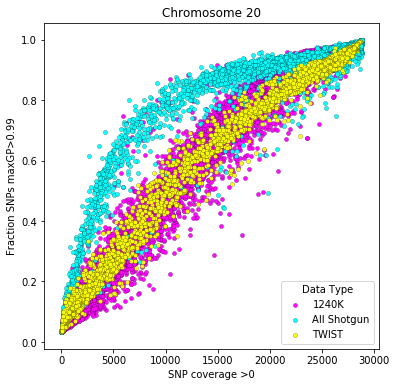

In [13]:
plt.figure(figsize=(6,6))
ax = plt.gca()

s=18
lw=0.2
ax.scatter(df_1240k["cov"], df_1240k["gp_frac"], c="magenta", ec="k", alpha=0.95, label="1240K",s=s, lw=lw)

ax.scatter(df_wgs1["cov"], df_wgs1["gp_frac"], c="aqua", ec="k", alpha=0.95, label="All Shotgun", s=s, lw=lw)
ax.scatter(df_twist["cov"], df_twist["gp_frac"], c="yellow", ec="k", alpha=0.95, label="TWIST", s=s, lw=lw)
#df_w = df_wgs[df_wgs["study"]=="AntonioGaoMootsScience2019"]
#ax.scatter(df_w["cov"], df_w["gp_frac"], c="green", ec="k", alpha=0.8, label="Antonio et al 2019")

#df_w = df_wgs[df_wgs["study"]=="MargaryanWillerslevNature2020"]
#ax.scatter(df_w["cov"], df_w["gp_frac"], c="red", ec="k", alpha=0.8, label="Margaryan et al 2020")

#df_w = df_wgs[df_wgs["study"]==]
#ax.scatter(df_w["cov"], df_w["gp_frac"], c="yellow", ec="k", alpha=0.8, label="Cassidy et al 2020")

#df_w = df_wgs[df_wgs["study"]=="SeguinOrlandoCurrBio2021"]
#ax.scatter(df_w["cov"], df_w["gp_frac"], c="orange", ec="k", alpha=0.8, label="Orlando et al 2021")

ax.set_xlabel("SNP coverage >0")
ax.set_ylabel("Fraction SNPs maxGP>0.99")
ax.set_title("Chromosome 20")
ax.legend(loc="lower right", title="Data Type")

plt.savefig("./figs/dumpster/imputation_QC_ch20.pdf", bbox_inches ='tight', pad_inches = 0, dpi=400)
plt.show()

# Plot coverage per SNP

In [ ]:
plt.figure(figsize=(6,6))
ax = plt.gca()

s=18
lw=0.2
ax.scatter(df_1240k["avg_cov_snp"], df_1240k["gp_frac"], c="magenta", ec="k", alpha=0.95, label="1240K",s=s, lw=lw)

ax.scatter(df_wgs1["avg_cov_snp"], df_wgs1["gp_frac"], c="aqua", ec="k", alpha=0.95, label="All Shotgun", s=s, lw=lw)
ax.scatter(df_twist["avg_cov_snp"], df_twist["gp_frac"], c="yellow", ec="k", alpha=0.95, label="TWIST", s=s, lw=lw)

ax.set_xlabel("SNP coverage >0")
ax.set_ylabel("Fraction SNPs maxGP>0.99")
ax.set_title("Chromosome 20")
ax.legend(loc="lower right", title="Data Type")

plt.savefig("./figs/dumpster/imputation_QC_ch20_avg.cov.pdf", bbox_inches ='tight', pad_inches = 0, dpi=400)
plt.show()

# Filter bad shotgun data

In [ ]:
df_wgs1[(df_wgs1["cov"]>55000) & (df_wgs1["gp_frac"]<0.8)]

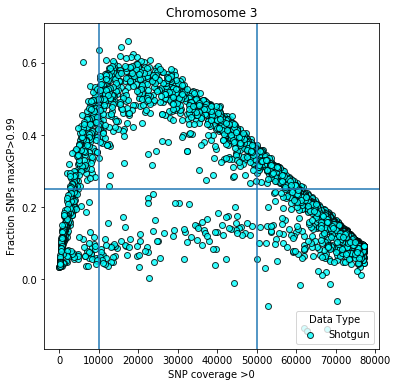

In [20]:
plt.figure(figsize=(6,6))
ax = plt.gca()
ax.scatter(df_wgs1["cov"], df_wgs1["gp_frac"]-df_wgs1["cov"]/85000, c="aqua", ec="k", alpha=0.8, label="Shotgun")
ax.set_xlabel("SNP coverage >0")
ax.set_ylabel("Fraction SNPs maxGP>0.99")
ax.set_title("Chromosome 3")
ax.legend(loc="lower right", title="Data Type")
ax.axhline(0.25)
ax.axvline(50000)
ax.axvline(10000)
plt.show()

In [21]:
cov_quality = df_wgs1["gp_frac"]-df_wgs1["cov"]/85000
idx = cov_quality<0.25
idx1 = (df_wgs1["cov"]>10000) & (df_wgs1["cov"]<50000)
df_f = df_wgs1[idx & idx1]

In [22]:
df_f["study"].value_counts()

Unpublished (Alissa Dusan Mesolithic-Neolithic)                                            14
KilincSciAdv2021                                                                           14
McCollScience2018                                                                          11
SikoraNature2019                                                                           10
CoutinhoJakobssonAJPA2020                                                                  10
Unpublished (shotgun)                                                                       8
Unpublished                                                                                 6
BraceDiekmannNatureEcologyEvolution2019                                                     6
SanchezQuintoPNAS2019                                                                       6
WangCell2021                                                                                3
Unpublished (Arie Finkelstein Israel IA)                    

In [ ]:
df_wgs[df_wgs["study"]=="Unpublished (Alissa Dusan Mesolithic-Neolithic)"]

# Plot AF against each other

In [13]:
%%time
# 7s for 1000 indivdiuals.
# 2min52s for 33967 indivdiuals
with h5py.File(f"{folder_in}{ch}.h5", "r") as f: # Load for Sanity Check. See below!
    print(list(f))
    print(list(f["calldata"]))
    print(list(f["variants"]))
    af_all = f["variants/AF_ALL"][:]
    af= f["variants/AF"][:,0]
    raf= f["variants/RAF"][:,0]


['calldata', 'samples', 'variants']
['AD', 'DS', 'GP', 'GT', 'HS', 'PL']
['AF', 'AF_ALL', 'ALT', 'BUF', 'CHROM', 'FILTER_PASS', 'ID', 'INFO', 'MAP', 'POS', 'QUAL', 'RAF', 'REF', 'altlen', 'is_snp', 'numalt']
CPU times: user 14.8 ms, sys: 6.2 ms, total: 21 ms
Wall time: 26.9 ms


## Various AF Fields
- AF_ALL: Allele frequency in sample
- AF/RAF: 1000 Genome AF

In [14]:
raf

array([0.218051, 0.439497, 0.572085, ..., 0.235224, 0.366014, 0.348842],
      dtype=float32)

In [15]:
af

array([0.177445, 0.338913, 0.498729, ..., 0.221925, 0.44214 , 0.427107],
      dtype=float32)

In [12]:
af_all

array([0.21648808, 0.41895154, 0.62601215, ..., 0.13793853, 0.3216552 ,
       0.29335806], dtype=float32)

In [44]:
# Return Pearson product-moment correlation coefficients.
np.corrcoef(af, raf)

array([[1.        , 0.82483688],
       [0.82483688, 1.        ]])

In [22]:
np.corrcoef(af_all, raf)

array([[1.       , 0.9688664],
       [0.9688664, 1.       ]])

In [23]:
np.corrcoef(af_all, af)

array([[1.        , 0.84584855],
       [0.84584855, 1.        ]])

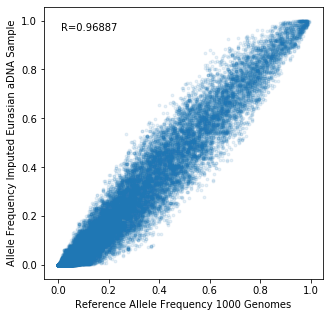

In [50]:
plt.figure(figsize=(5,5))
ax = plt.gca()
ax.scatter(raf, af_all, alpha=0.1, s=8)
ax.set_xlabel("Reference Allele Frequency 1000 Genomes")
ax.set_ylabel("Allele Frequency Imputed Eurasian aDNA Sample")

c = np.corrcoef(raf, af_all)[0,1]
t = f"R={c:.5f}"
ax.text(0.01,0.99,t, va="top", ha="left")
plt.show()

In [24]:
in_vcf_path = f"/n/data1/hms/genetics/reich/1000Genomes/ali/WholeGenomeImputation/imputed_r2/v54.1/chr3.bcf"

In [27]:
!bcftools view $in_vcf_path | head -10

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##fileDate=10/09/2022 - 05:26:26
##source=GLIMPSE_phase v1.0.0
##contig=<ID=3>
##INFO=<ID=RAF,Number=A,Type=Float,Description="ALT allele frequency in the reference panel">
##INFO=<ID=AF,Number=A,Type=Float,Description="ALT allele frequency computed from DS/GP field across target samples">
##INFO=<ID=INFO,Number=A,Type=Float,Description="Imputation information or quality score">
##INFO=<ID=BUF,Number=A,Type=Integer,Description="Is it a variant site falling within buffer regions? (0=no/1=yes)">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Unphased genotypes">
[main_vcfview] Error: cannot write to (null)


# Area 51

In [50]:
df_meta["Master ID"].value_counts()

I1685     8
I4012     8
I2963     8
I10872    7
I1072     6
         ..
I19644    1
I17589    1
FNO007    1
I11991    1
I17352    1
Name: Master ID, Length: 29307, dtype: int64

In [ ]:
dft

In [ ]:
df.to_csv(f"./notebook/vignette/data/afs/v51.1_1240k_AF_ch{ch}.tsv", sep="\t", index=False)